<a href="https://colab.research.google.com/github/Dssdiego/ai_trabalho2/blob/main/ai_trabalho_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho 2

Escolha uma base de dados do seu interesse e desenvolva um modelo de regressão ou classificação para descrever uma variável a partir das demais

**Aluno:** Diego S. Seabra <br>
**Matrícula:** 0040251 <br>
**Disciplina:** Inteligência Artificial Avançada <br>

Os dados escolhidos foram retirados do Kaggle.

São dados de carros usados para a venda nos EUA

In [ ]:
# Importações
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import requests
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

In [ ]:
# Leitura dos dados
df = pd.read_csv("https://raw.githubusercontent.com/Dssdiego/ai_trabalho2/main/car_data.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7905 entries, 0 to 8127
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   maker          7905 non-null   object 
 1   car            7905 non-null   object 
 2   model          7905 non-null   object 
 3   year           7905 non-null   int64  
 4   year_usage     7905 non-null   int64  
 5   selling_price  7905 non-null   int64  
 6   km_driven      7905 non-null   int64  
 7   fuel           7905 non-null   object 
 8   seller_type    7905 non-null   object 
 9   transmission   7905 non-null   object 
 10  owner          7905 non-null   object 
 11  mileage        7905 non-null   object 
 12  engine         7905 non-null   object 
 13  max_power      7905 non-null   object 
 14  torque         7905 non-null   object 
 15  seats          7905 non-null   float64
dtypes: float64(1), int64(4), object(11)
memory usage: 1.3+ MB


In [ ]:
# Verificamos primeiro a quantidade de dados faltantes (NaN) no dataset
df.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

In [ ]:
# Calculamos então a porcentagem de NaNs em relação ao dataset inteiro
df.isna().sum().max()/len(df.index) * 100

2.731299212598425

In [ ]:
# Como a porcentagem é de apenas 2,73% e os dados faltantes
# são relacionados às informações "internas" de um veículo (motor, torque, 
# assentos, etc), excluiremos as linhas do dataset que não possuem tais valores
df = df.dropna()

In [ ]:
# Vamos utilizar a primeira coluna do dataset (name) para criar outras colunas
# importantes na nossa análise
df['name']

0             Maruti Swift Dzire VDI
1       Skoda Rapid 1.5 TDI Ambition
2           Honda City 2017-2020 EXi
3          Hyundai i20 Sportz Diesel
4             Maruti Swift VXI BSIII
                    ...             
8123               Hyundai i20 Magna
8124           Hyundai Verna CRDi SX
8125          Maruti Swift Dzire ZDi
8126                 Tata Indigo CR4
8127                 Tata Indigo CR4
Name: name, Length: 7906, dtype: object

In [ ]:
# Criamos as colunas de fabricante (maker), carro (car) e modelo (model)
makers = df['name'].apply(lambda x: x.split(' ')[0])
cars = df['name'].apply(lambda x: x.split(' ')[1])
models = df['name'].apply(lambda x: " ".join(x.split(' ')[2:]))

df.insert(0, 'maker', makers)
df.insert(1, 'car', cars)
df.insert(2, 'model', models)

In [ ]:
# Removemos a coluna "name" (pois ela não será mais utilizada)
del df['name']

In [ ]:
# Na análise, foi encontrado um veículo que possuia apenas 1 km rodado
# indicando que o dado foi salvo de forma incorreta.
df.loc[df['km_driven'] < 1000]

,maker,car,model,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
7913,Maruti,Eeco,5 STR With AC Plus HTR CNG,2011,209000,1,CNG,Individual,Manual,Fourth & Above Owner,15.1 km/kg,1196 CC,73 bhp,101Nm@ 3000rpm,5.0


In [ ]:
# Portanto é feita a remoção deste item
df.drop(7913, inplace=True)

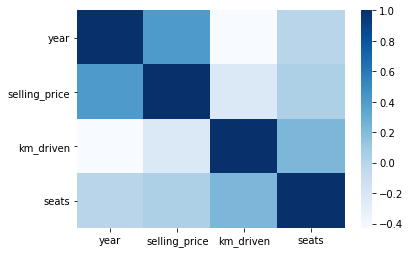

In [ ]:
# Verificamos se há correlação entre algumas das colunas
sns.heatmap(data=df.corr(), cmap='Blues')
plt.show()

In [ ]:
df.corr()

,year,selling_price,km_driven,seats
year,1.000000,0.412272,-0.428724,-0.007966
selling_price,0.412272,1.000000,-0.222267,0.041588
km_driven,-0.428724,-0.222267,1.000000,0.227217
seats,-0.007966,0.041588,0.227217,1.000000


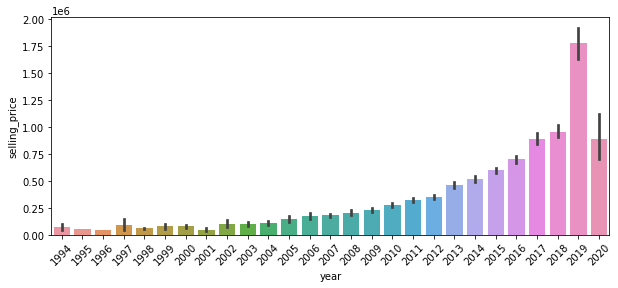

In [ ]:
# Podemos perceber que há uma correlação significativa (0.41 ou 41%)
# entre o ano e o preço de venda. 

# Isso faz sentido pois quanto mais novo o carro, maior será o preço de venda
# Podemos visualizar isso no gráfico a seguir
plt.figure(figsize=(10,4))
sns.barplot(data=df, x='year', y='selling_price')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Criamos então uma nova coluna (year_usage) que demonstrará o tempo de uso
# que o carro tem (em anos)

currYear = datetime.datetime.now().year
years_usage = df['year'].apply(lambda x: currYear - x)

df.insert(4, 'year_usage', years_usage)

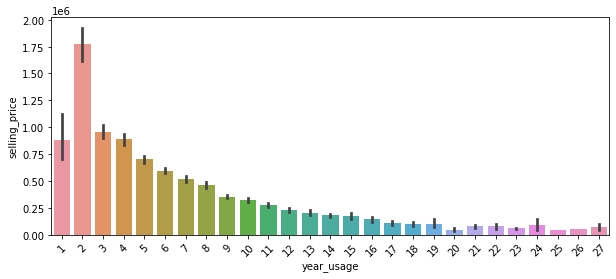

In [ ]:
# E comparamos os valores dos veículos em relação ao tempo de uso
# Aqui o gráfico deveria ser exatamente o contrário do gráfico anterior.
# Ou seja, quanto maior o tempo de uso, mais barato o preço
# pelo qual o carro será vendido
plt.figure(figsize=(10,4))
sns.barplot(data=df, x='year_usage', y='selling_price')
plt.xticks(rotation=45)
plt.show()

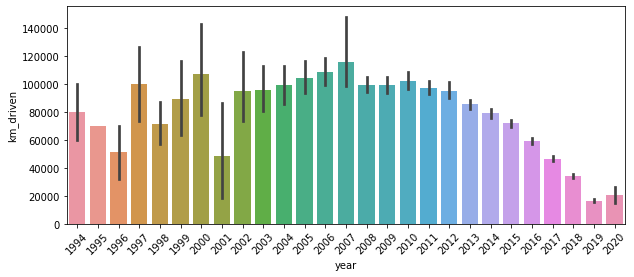

In [ ]:
# Existe alguma relação entre o ano do carro e o número de quilômetros rodados?
plt.figure(figsize=(10,4))
sns.barplot(data=df, x='year', y='km_driven')
plt.xticks(rotation=45)
plt.show()

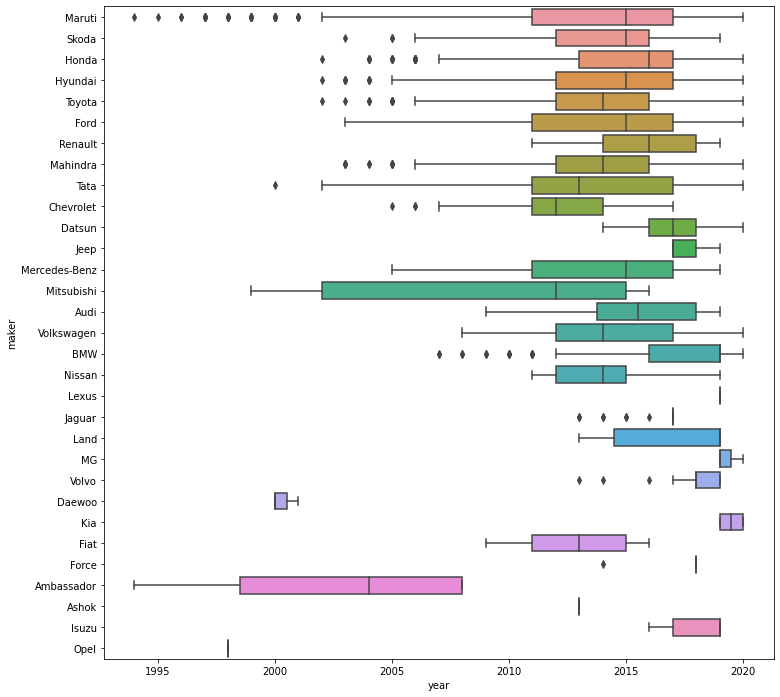

In [ ]:
# Verificamos a distribuição das marcas de veículos
# em comparação com a data
plt.figure(figsize=(12,12))
sns.boxplot(data=df, x='year', y='maker')
plt.show()

In [ ]:
# Quais as 10 marcas mais caras?
df.groupby('maker')['selling_price'].sum().sort_values(ascending=False).head(10).to_frame()

,selling_price
maker,
Maruti,967920371
Hyundai,643661446
BMW,490150000
Mahindra,477555971
Toyota,457387978
Honda,278165133
Tata,260172902
Volvo,219225000
Jaguar,206998000


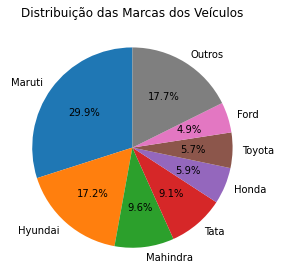

In [ ]:
# Distribuição das marcas dos veículos
lim = 7
x = pd.value_counts(df['maker'])
cat = x[:lim].index.values
freq = x[:lim].values

cat = np.append(cat, ['Outros'])
freq = np.append(freq, np.sum(x[lim:]))

plt.pie(freq, labels=cat, startangle=90, autopct='%1.1f%%')
plt.title('Distribuição das Marcas dos Veículos')
plt.tight_layout()
plt.show()

In [ ]:
# Quantos carros de cada marca existem no dataset?
df['maker'].value_counts().to_frame()

,maker
Maruti,2366
Hyundai,1360
Mahindra,758
Tata,719
Honda,466
Toyota,452
Ford,388
Chevrolet,230
Renault,228
Volkswagen,185


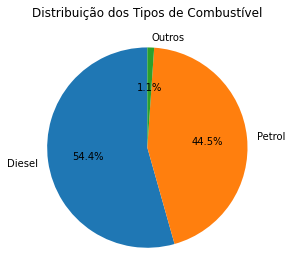

In [ ]:
# Distribuição dos tipos de combustível
lim = 2
x = pd.value_counts(df['fuel'])
cat = x[:lim].index.values
freq = x[:lim].values

cat = np.append(cat, ['Outros'])
freq = np.append(freq, np.sum(x[lim:]))

plt.pie(freq, labels=cat, startangle=90, autopct='%1.1f%%')
plt.title('Distribuição dos Tipos de Combustível')
plt.tight_layout()
plt.show()

In [ ]:
# Qual o tipo de combustível mais usado nos veículos?
df['fuel'].value_counts().to_frame()

,fuel
Diesel,4299
Petrol,3520
CNG,51
LPG,35


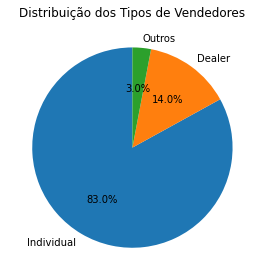

In [ ]:
# Distribuição dos tipos de vendedores
lim = 2
x = pd.value_counts(df['seller_type'])
cat = x[:lim].index.values
freq = x[:lim].values

cat = np.append(cat, ['Outros'])
freq = np.append(freq, np.sum(x[lim:]))

plt.pie(freq, labels=cat, startangle=90, autopct='%1.1f%%')
plt.title('Distribuição dos Tipos de Vendedores')
plt.tight_layout()
plt.show()

In [ ]:
# Normalmente os carros são vendidos por pessoas ou por distribuidoras?
df['seller_type'].value_counts().to_frame()

,seller_type
Individual,6562
Dealer,1107
Trustmark Dealer,236


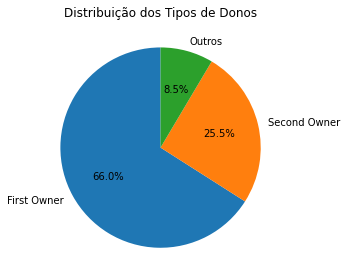

In [ ]:
# Distribuição dos tipos de donos
lim = 2
x = pd.value_counts(df['owner'])
cat = x[:lim].index.values
freq = x[:lim].values

cat = np.append(cat, ['Outros'])
freq = np.append(freq, np.sum(x[lim:]))

plt.pie(freq, labels=cat, startangle=90, autopct='%1.1f%%')
plt.title('Distribuição dos Tipos de Donos')
plt.tight_layout()
plt.show()

In [ ]:
# Qual o dono mais frequente nos carros vendidos? (1º, 2º, ...)
df['owner'].value_counts().to_frame()

,owner
First Owner,5215
Second Owner,2016
Third Owner,510
Fourth & Above Owner,159
Test Drive Car,5


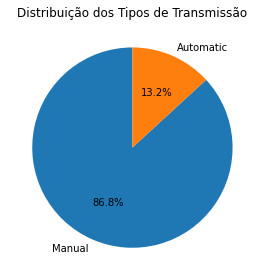

In [ ]:
# Distribuição dos tipos de transmissão
x = pd.value_counts(df['transmission'])
cat = x.index.values
freq = x.values

plt.pie(freq, labels=cat, startangle=90, autopct='%1.1f%%')
plt.title('Distribuição dos Tipos de Transmissão')
plt.tight_layout()
plt.show()

In [ ]:
# Qual a transmissão mais frequente?
df['transmission'].value_counts().to_frame()

,transmission
Manual,6864
Automatic,1041


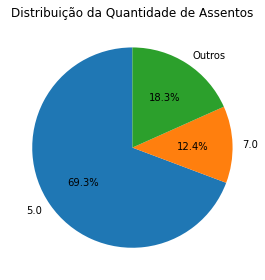

In [ ]:
# Distribuição da quantidade de assentos
lim = 7
x = pd.value_counts(df['seats'])
cat = x[:lim].index.values
freq = x[:lim].values

cat = np.append(cat, ['Outros'])
freq = np.append(freq, np.sum(x[lim:]))

plt.pie(freq, labels=cat, startangle=90, autopct='%1.1f%%')
plt.title('Distribuição da Quantidade de Assentos')
plt.tight_layout()
plt.show()

In [ ]:
# Qual o número de assentos mais frequente?
df['seats'].value_counts().to_frame()

,seats
5.0,6253
7.0,1120
8.0,235
4.0,133
9.0,80
6.0,62
10.0,19
2.0,2
14.0,1


In [ ]:
# Por curiosidade vamos ver qual é este veículo que possui 14 assentos
df.loc[df['seats'] == 14.0]

,maker,car,model,year,year_usage,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
4575,Tata,Winger,Deluxe - Flat Roof (Non-AC),2010,11,235000,50000,Diesel,Individual,Manual,First Owner,10.71 kmpl,1948 CC,90 bhp,190Nm@ 2000-3000rpm,14.0


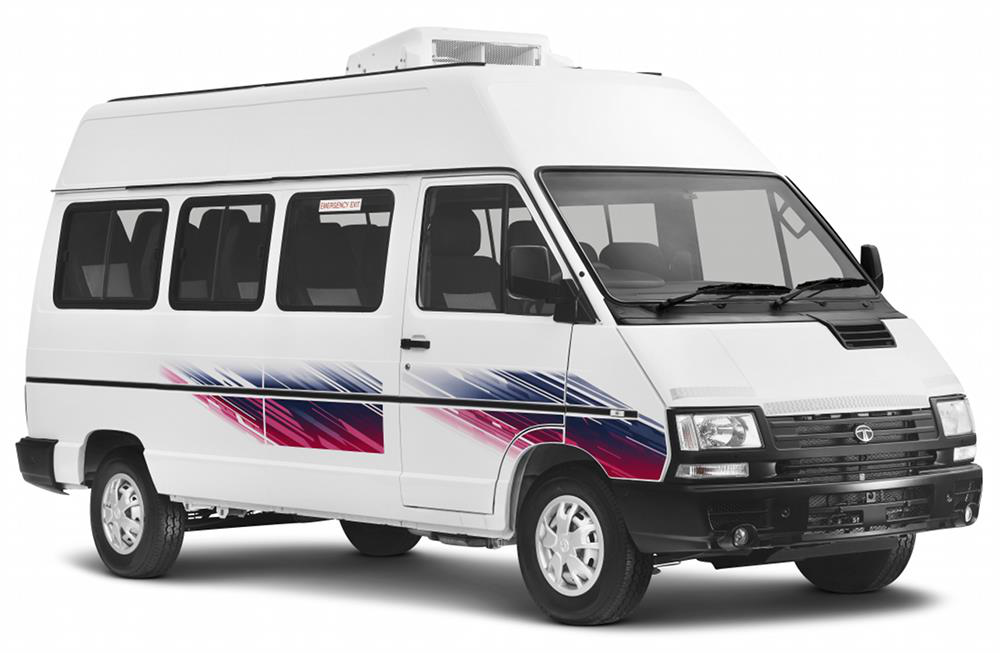

In [ ]:
# Abrindo a imagem do veículo podemos perceber o que já era esperado: É uma van!
Image.open(requests.get("https://ic1.maxabout.us/autos/cars_india//N/2018/11/new-tata-winger-15s.jpg", stream=True).raw)

In [ ]:
# Quais os 10 carros com menos quilômetros rodados?
df.sort_values(by='km_driven', ascending=True).head(10)

,maker,car,model,year,year_usage,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
7589,Maruti,Swift,LXI,2020,1,445000,1000,Petrol,Individual,Manual,First Owner,21.21 kmpl,1197 CC,81.80 bhp,113Nm@ 4200rpm,5.0
7429,Maruti,Swift,LXI,2020,1,445000,1000,Petrol,Individual,Manual,First Owner,21.21 kmpl,1197 CC,81.80 bhp,113Nm@ 4200rpm,5.0
7492,Hyundai,Santro,Magna,2020,1,500000,1000,Petrol,Individual,Manual,First Owner,20.3 kmpl,1086 CC,68.07 bhp,99.07Nm@ 4500rpm,5.0
399,Honda,City,i-VTEC CVT V,2018,3,1085000,1000,Petrol,Individual,Automatic,First Owner,18.0 kmpl,1497 CC,117.6 bhp,145Nm@ 4600rpm,5.0
6638,Toyota,Innova,Crysta 2.4 ZX AT,2020,1,2300000,1000,Diesel,Individual,Automatic,First Owner,13.68 kmpl,2393 CC,147.51 bhp,360Nm@ 1400-2600rpm,7.0
2963,Maruti,Swift,AMT VXI,2020,1,654000,1000,Petrol,Individual,Automatic,First Owner,21.21 kmpl,1197 CC,81.80 bhp,113Nm@ 4200rpm,5.0
6163,Datsun,RediGO,SV 1.0,2019,2,325000,1300,Petrol,Individual,Manual,First Owner,22.5 kmpl,999 CC,67 bhp,91Nm@ 4250rpm,5.0
5244,Honda,Amaze,S i-VTEC,2019,2,690000,1303,Petrol,Dealer,Manual,First Owner,17.8 kmpl,1198 CC,86.7 bhp,109Nm@ 4500rpm,5.0
3235,Honda,Amaze,S i-VTEC,2019,2,690000,1303,Petrol,Dealer,Manual,First Owner,17.8 kmpl,1198 CC,86.7 bhp,109Nm@ 4500rpm,5.0
1560,Honda,Amaze,S i-VTEC,2019,2,690000,1303,Petrol,Dealer,Manual,First Owner,17.8 kmpl,1198 CC,86.7 bhp,109Nm@ 4500rpm,5.0


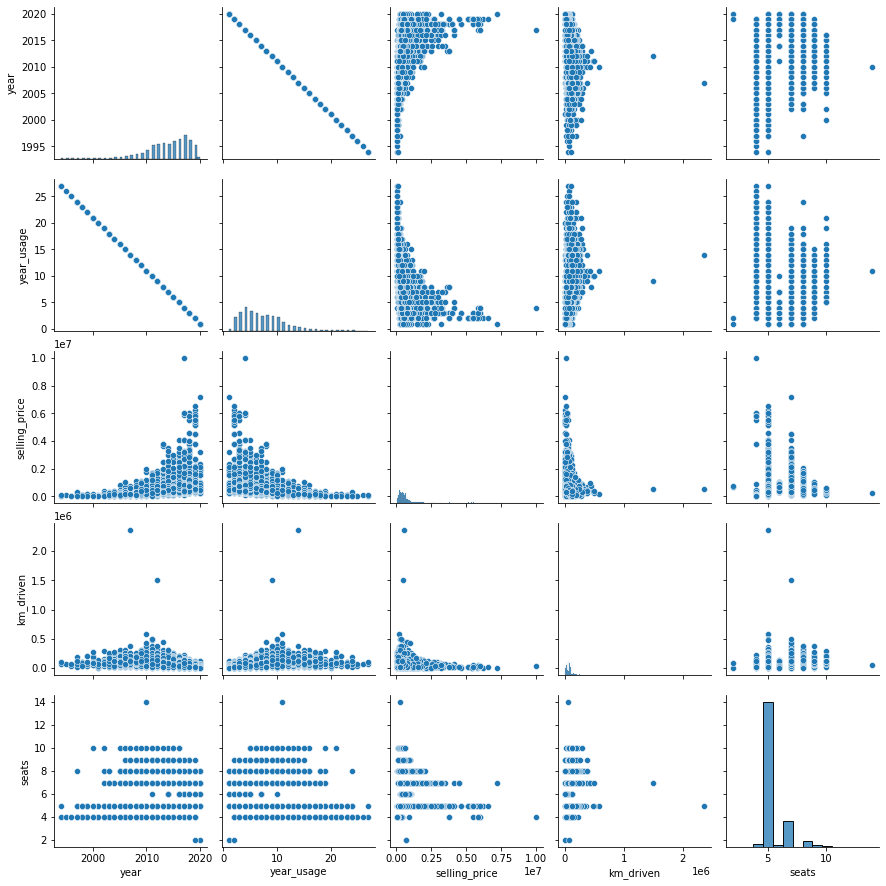

In [ ]:
# Utilizamos o pairplot do Seaborn para tentar identificar 
# outras informações importantes no dataset
sns.pairplot(data=df)

In [ ]:
# Criamos um modelo que fará a previsão dos preços com base nas outras colunas

# O valor do X são todas as colunas exceto o preço de venda
X = df.drop('selling_price', axis=1)
# O valor do y é o preço de venda
y = df['selling_price']

# Separa as features em categorias (colunas do dataset)
categorical_features = X.select_dtypes(include='object').columns

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_new = preprocessor.fit_transform(X)

# Treinamos para vários modelos e verificamos os scores
modelos = [ # LogisticRegression()       # 0.079
           # RandomForestClassifier(),   # 0.594
            KNeighborsClassifier(),
            LinearRegression(), 
            DecisionTreeClassifier(),
            RandomForestRegressor(),
            DecisionTreeRegressor()
            ]

print('Scores')
for modelo in modelos:
  model = modelo
  model.fit(X_new, y)
  print('{}\t: {}'.format(type(modelo).__name__, model.score(X_new, y)))

[[ 20. 152. 939. ...  13. 242. 178.]
 [ 26. 126. 232. ...  36.  13. 260.]
 [ 10.  35. 524. ...  35. 251.  66.]
 ...
 [ 20. 152. 951. ...  13. 239. 178.]
 [ 27.  83. 767. ...  24. 230. 106.]
 [ 27.  83. 767. ...  24. 230. 106.]]
Scores
KNeighborsClassifier	: 0.3396584440227704
LinearRegression	: 0.4657883515081333
DecisionTreeClassifier	: 0.5940543959519291
RandomForestRegressor	: 0.986783469589065
DecisionTreeRegressor	: 0.9925788390649556


In [ ]:
# Usamos o modelo com o maior score
model = DecisionTreeRegressor()

In [ ]:
# Separamos o dataset em conjuntos de treino e teste
# 80% treino / 20% teste
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2)

# Realizamos a previsão do modelo
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Verificamos os scores do modelo de regressão
print('R2 Score:', r2_score(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('MSE:', mean_squared_error(y_test, y_pred, squared=True))

R2 Score: 0.9535170574411767
RMSE: 176358.47199390107
MSE: 31102310644.02359


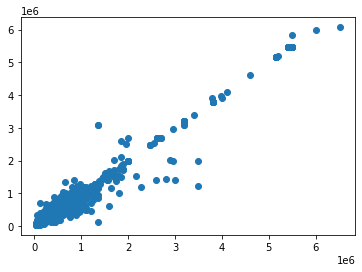

In [ ]:
plt.scatter(y_test, y_pred)
plt.show()

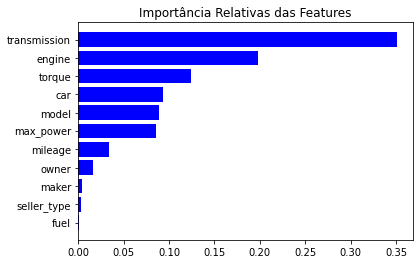

In [ ]:
# Verificamos a importância relativa de cada feature no dataset

features = categorical_features
importances = model.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Importância Relativas das Features')
plt.show()

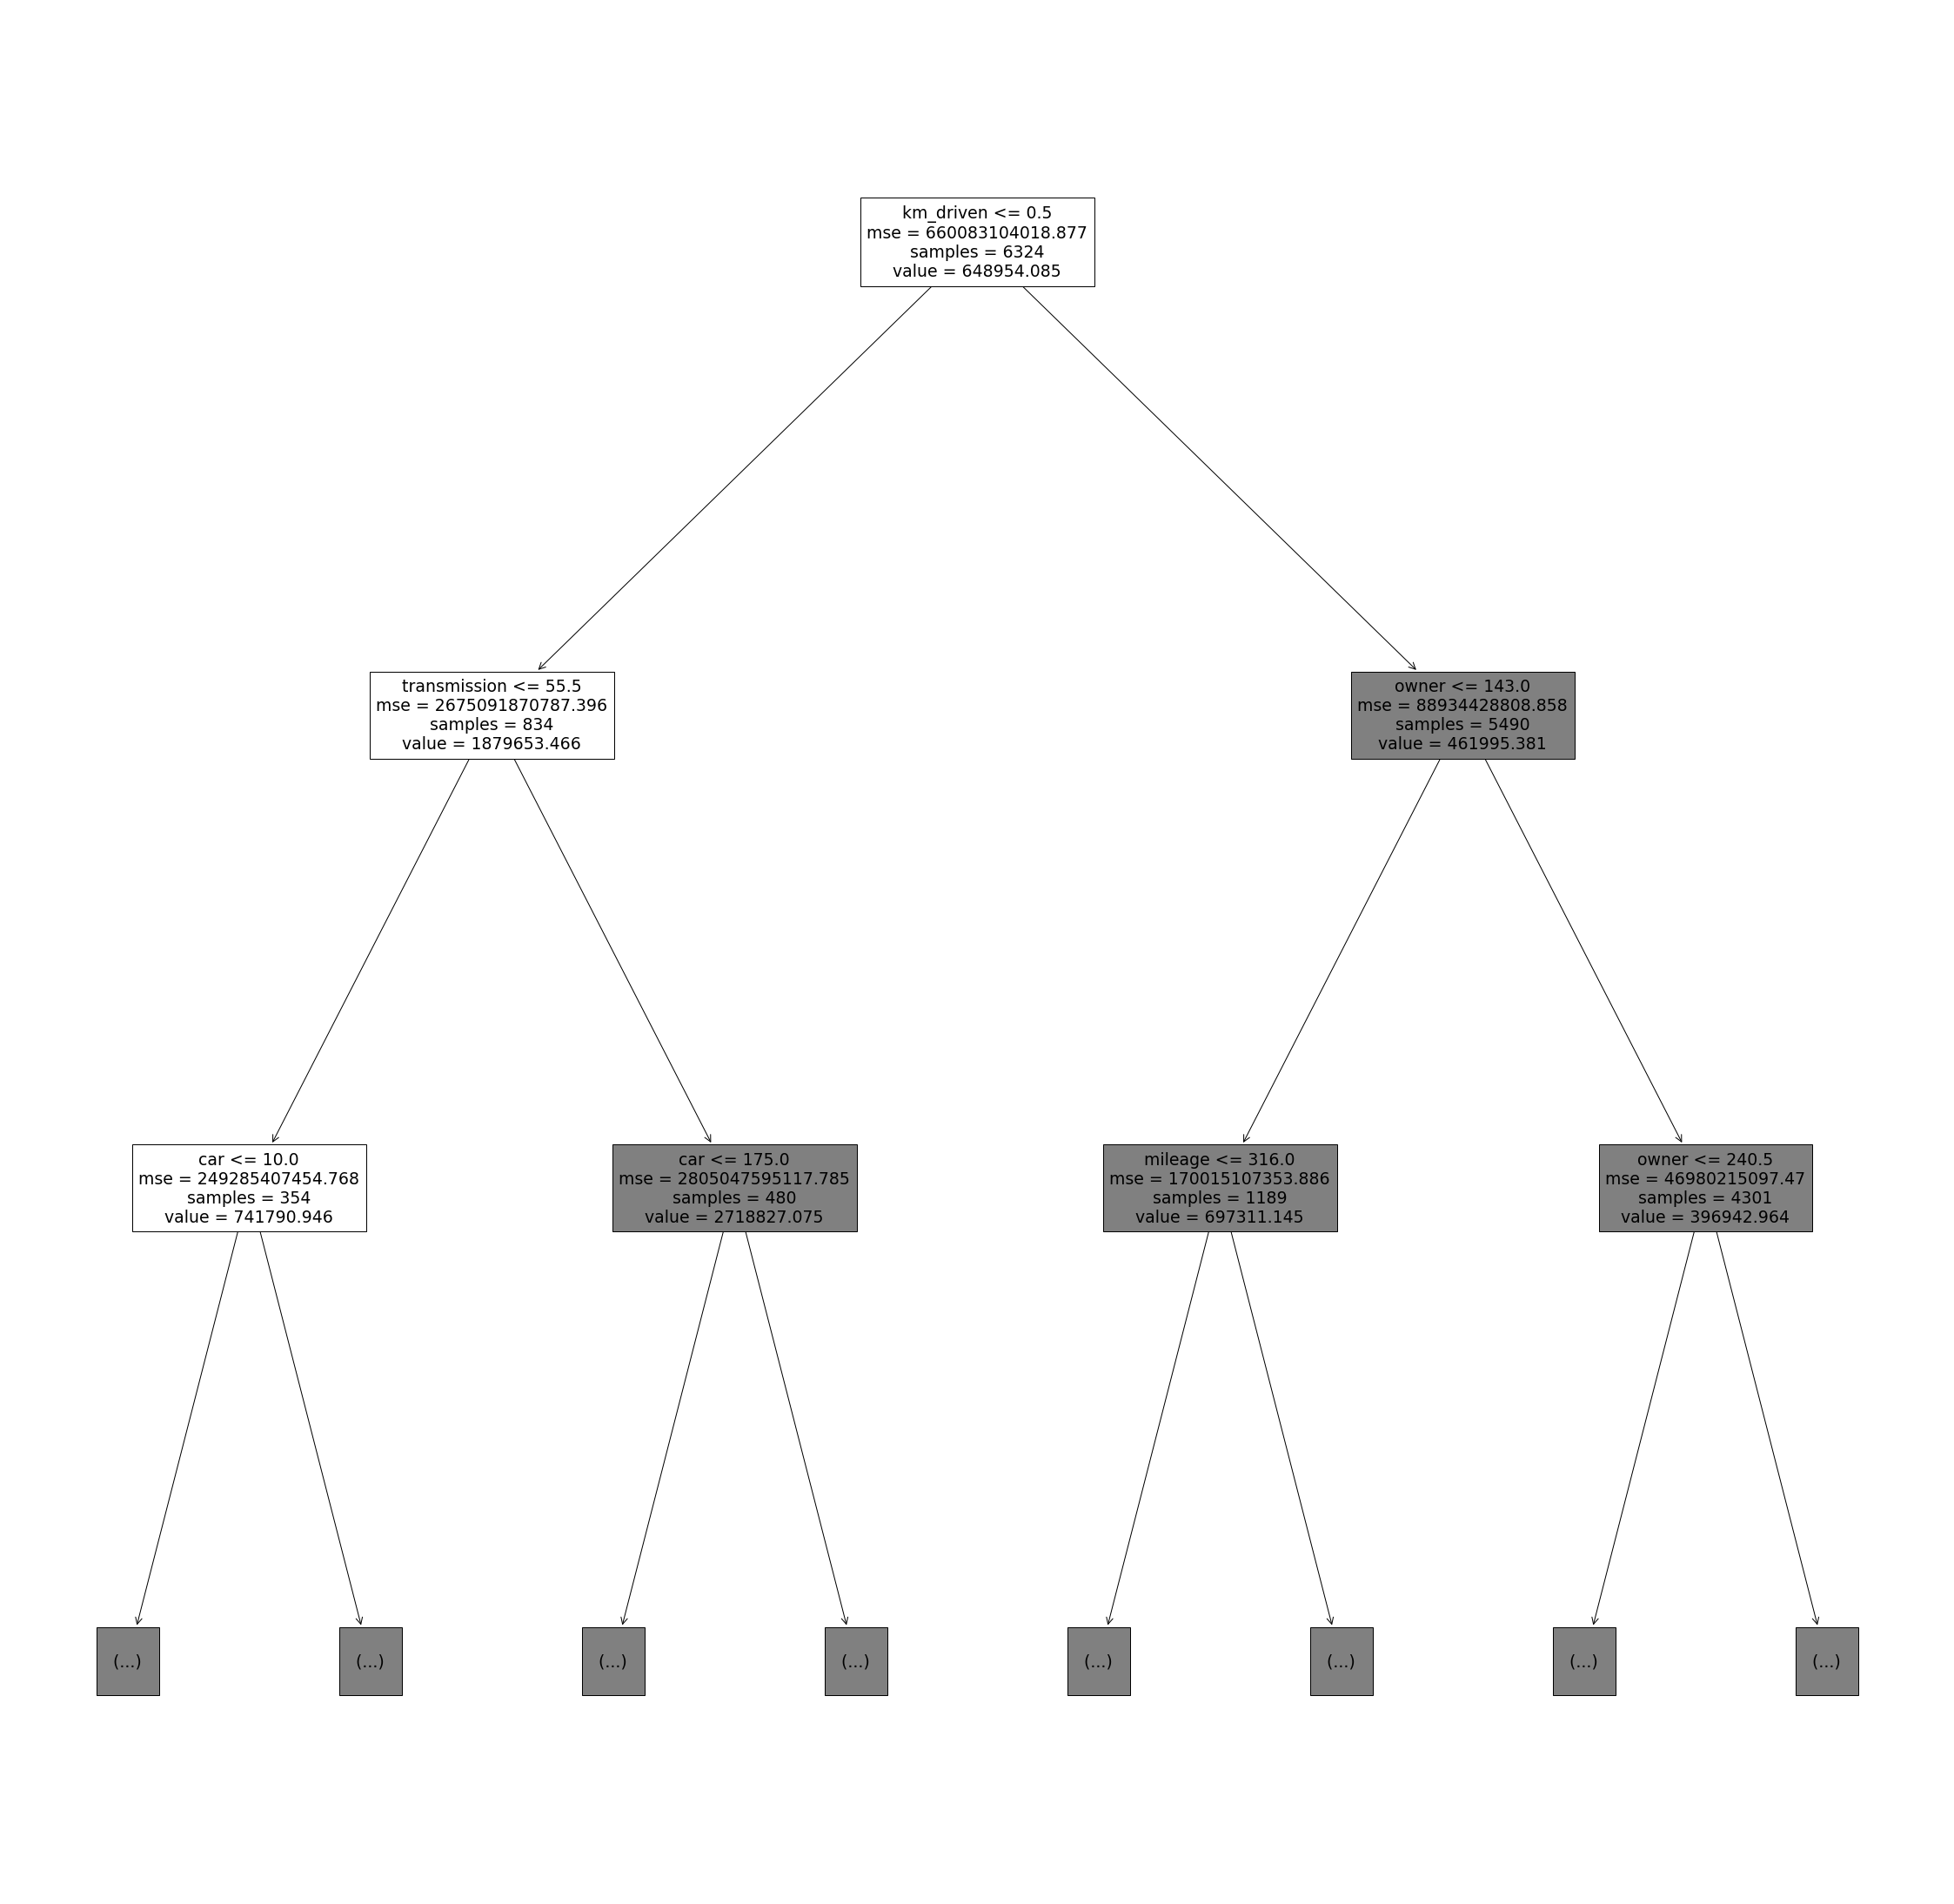

In [ ]:
# Visualizamos a àrvore de decisão que foi criada pelo modelo

plt.figure(figsize=(40,40))
plot_tree(model, max_depth=2, feature_names=X.columns) # Profundidade de 2 somente para uma visualização rápida do modelo
plt.show()